# Mixed Reversal + Momentum — Walk-Forward Validation

We validate an **equal-volatility mix** of cross-sectional **Reversal** (daily rebalance) and **Momentum** (monthly rebalance) on hourly crypto data using **expanding** and **rolling** walk-forward splits. We report out-of-sample (OOS) performance, **alpha/beta vs BTC**, and **cost sensitivity** at 7/10/20 bps.

In [1]:
# --- Core ---
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
import sys

# --- Display ---
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)

# --- Paths ---
PROJECT_ROOT = Path.cwd().parent          # .../crypto-stat-arb
SRC_DIR = PROJECT_ROOT / "src"            # .../crypto-stat-arb/src
PKG_DIR = SRC_DIR / "crypto_stat_arb"     # .../crypto-stat-arb/src/crypto_stat_arb
DATA_DIR = SRC_DIR / "data"               # .../crypto-stat-arb/src/data

# Make the package importable
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Config ---
from crypto_stat_arb.config import ANNUALIZATION, COST_BPS, COST_RATE
from crypto_stat_arb.load import load_panels
from crypto_stat_arb.signals import cs_momentum_weights, cs_reversal_weights
from crypto_stat_arb.portfolio import downsample_weights
from crypto_stat_arb.backtest import backtest, perf_stats
from crypto_stat_arb.stats import rolling_sharpe, perf_summary_from_series_exact, compute_alpha_beta
from crypto_stat_arb.walkforward import run_walk_forward_mixed

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)
print("PKG_DIR exists:", PKG_DIR.exists())
print("DATA_DIR:", DATA_DIR)
print("ANNUALIZATION:", ANNUALIZATION, "| COST_BPS:", COST_BPS, "| COST_RATE:", COST_RATE)

PROJECT_ROOT: C:\Users\Cameron Collins\crypto-stat-arb
SRC_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src
PKG_DIR exists: True
DATA_DIR: C:\Users\Cameron Collins\crypto-stat-arb\src\data
ANNUALIZATION: 8760 | COST_BPS: 7 | COST_RATE: 0.0007


In [2]:
# Load price/return panels via helper
px, ret = load_panels(DATA_DIR)

print("Coverage window:", ret.index.min(), "→", ret.index.max(), f"({len(ret):,} bars)")
print("N assets:", ret.shape[1])
print("Max NA frac:", float(ret.isna().mean().max()))

if ret.isna().any().any():
    ret = ret.ffill().dropna(how="any")
    px  = px.loc[ret.index, ret.columns]
    print("After fill/drop:", ret.shape)

BENCH = "BTCUSDT" if "BTCUSDT" in ret.columns else None

Coverage window: 2023-01-01 01:00:00+00:00 → 2025-08-14 00:00:00+00:00 (22,944 bars)
N assets: 12
Max NA frac: 0.0


Expanding folds: 6 | mean test Sharpe: 2.574 | median: 2.315
Rolling   folds: 6 | mean test Sharpe: 2.575 | median: 2.323


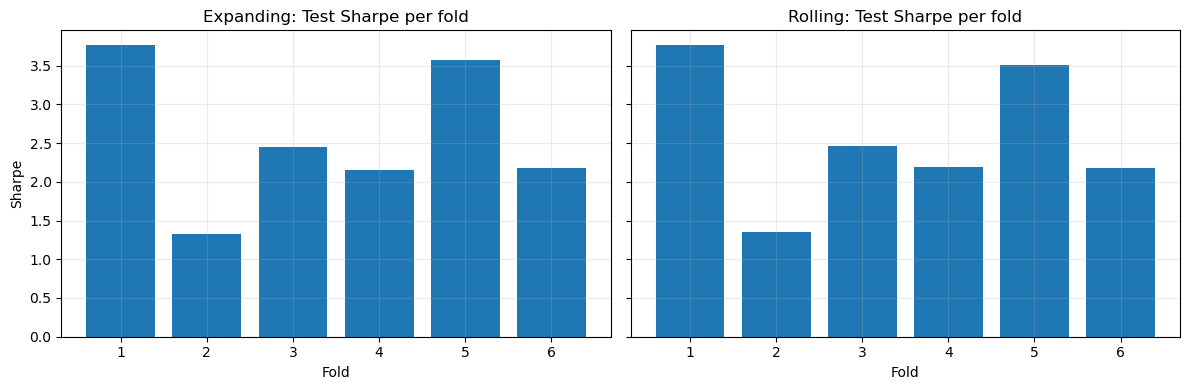

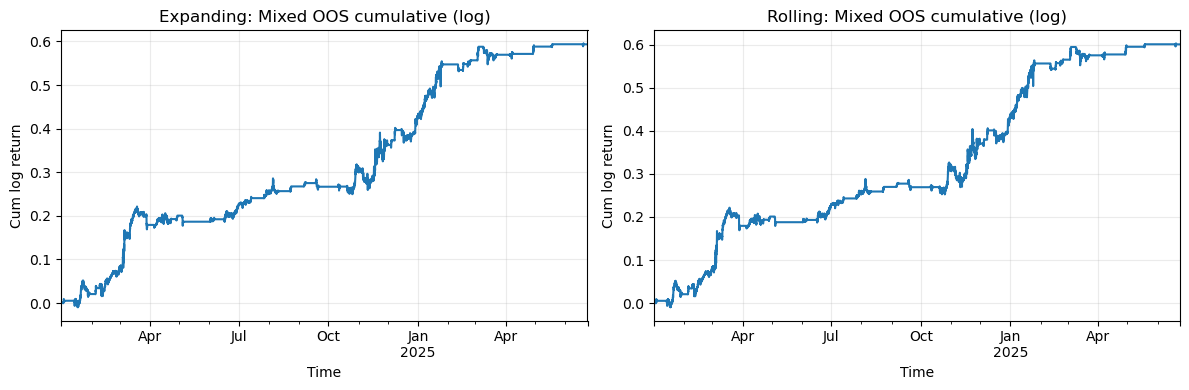

In [3]:
# --- Strategy params ---
params_rev = {"k": 4, "band": 2.5, "beta_win": 168, "vol_win": 24}
params_mom = {"k": 500, "band": 2.0, "beta_win": 168, "vol_win": None}
every_rev = 24
every_mom = 336

# --- Expanding ---
exp_df_mix, exp_oos_mix = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="expanding",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,   # <-- provide functions
    momentum_func=cs_momentum_weights,   # <--
)

# --- Rolling ---
roll_df_mix, roll_oos_mix = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="equal_vol",
    train_days=365, test_days=90, mode="rolling",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,   # <-- provide functions
    momentum_func=cs_momentum_weights,   # <--
)

print(
    "Expanding folds:", len(exp_df_mix),
    "| mean test Sharpe:", round(float(exp_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(exp_df_mix["test_sharpe"].median()), 3),
)
print(
    "Rolling   folds:", len(roll_df_mix),
    "| mean test Sharpe:", round(float(roll_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(roll_df_mix["test_sharpe"].median()), 3),
)

# --- Plots: per-fold Sharpe + stitched OOS cumulative (log) ---
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
ax[0].bar(exp_df_mix["fold"], exp_df_mix["test_sharpe"]); ax[0].set_title("Expanding: Test Sharpe per fold")
ax[0].set_xlabel("Fold"); ax[0].set_ylabel("Sharpe"); ax[0].grid(True, alpha=0.25)
ax[1].bar(roll_df_mix["fold"], roll_df_mix["test_sharpe"]); ax[1].set_title("Rolling: Test Sharpe per fold")
ax[1].set_xlabel("Fold"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12,4))
exp_oos_mix.fillna(0).cumsum().plot(ax=ax[0]); ax[0].set_title("Expanding: Mixed OOS cumulative (log)")
ax[0].set_xlabel("Time"); ax[0].set_ylabel("Cum log return"); ax[0].grid(True, alpha=0.25)
roll_oos_mix.fillna(0).cumsum().plot(ax=ax[1]); ax[1].set_title("Rolling: Mixed OOS cumulative (log)")
ax[1].set_xlabel("Time"); ax[1].set_ylabel("Cum log return"); ax[1].grid(True, alpha=0.25)
plt.tight_layout(); plt.show()

In [4]:
# Define benchmark series
if "bench_ret" not in globals():
    bench_ret = ret["BTCUSDT"] if "BTCUSDT" in ret.columns else ret.mean(axis=1)

# Grid for optimizing momentum weight on TRAIN each fold
OPT_GRID = np.linspace(0.0, 1.0, 51)

# Expanding (train-optimized mix)
exp_df_mix_opt, exp_oos_mix_opt = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="train_opt",
    opt_grid=OPT_GRID,
    train_days=365, test_days=90, mode="expanding",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)

# Rolling (train-optimized mix)
roll_df_mix_opt, roll_oos_mix_opt = run_walk_forward_mixed(
    ret,
    params_rev, params_mom,
    every_rev=every_rev, every_mom=every_mom,
    mix_mode="train_opt",
    opt_grid=OPT_GRID,
    train_days=365, test_days=90, mode="rolling",
    cost_bps=COST_BPS,
    reversal_func=cs_reversal_weights,
    momentum_func=cs_momentum_weights,
)

exp_df_mix, roll_df_mix   = exp_df_mix_opt, roll_df_mix_opt
exp_oos_mix, roll_oos_mix = exp_oos_mix_opt, roll_oos_mix_opt

# Summary
print(
    "Expanding (train-opt) — mean Sharpe:",
    round(float(exp_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(exp_df_mix["test_sharpe"].median()), 3),
    "| mean w_mom:", round(float(exp_df_mix["w_mom_mix"].mean()), 3),
)
print(
    "Rolling   (train-opt) — mean Sharpe:",
    round(float(roll_df_mix["test_sharpe"].mean()), 3),
    "| median:", round(float(roll_df_mix["test_sharpe"].median()), 3),
    "| mean w_mom:", round(float(roll_df_mix["w_mom_mix"].mean()), 3),
)

Expanding (train-opt) — mean Sharpe: 2.213 | median: 2.132 | mean w_mom: 0.397
Rolling   (train-opt) — mean Sharpe: 2.144 | median: 2.184 | mean w_mom: 0.507


In [5]:
# === Cost sensitivity (REFERENCE: Equal-Vol mix) ===
for bps in [7, 10, 20]:
    df_e, _ = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="expanding",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )
    df_r, _ = run_walk_forward_mixed(
        ret, params_rev, params_mom,
        every_rev=every_rev, every_mom=every_mom,
        mix_mode="equal_vol",
        train_days=365, test_days=90, mode="rolling",
        cost_bps=bps,
        reversal_func=cs_reversal_weights,
        momentum_func=cs_momentum_weights,
    )
    print(
        f"[Equal-Vol] Cost {bps} bps → Exp mean Sharpe={df_e['test_sharpe'].mean():.2f}, "
        f"Roll mean Sharpe={df_r['test_sharpe'].mean():.2f}"
    )

[Equal-Vol] Cost 7 bps → Exp mean Sharpe=2.57, Roll mean Sharpe=2.57
[Equal-Vol] Cost 10 bps → Exp mean Sharpe=2.47, Roll mean Sharpe=2.47
[Equal-Vol] Cost 20 bps → Exp mean Sharpe=2.11, Roll mean Sharpe=2.12


Saved figure to: C:\Users\Cameron Collins\crypto-stat-arb\figs\mixed_oos_pnl_train-optimized-per-fold.png


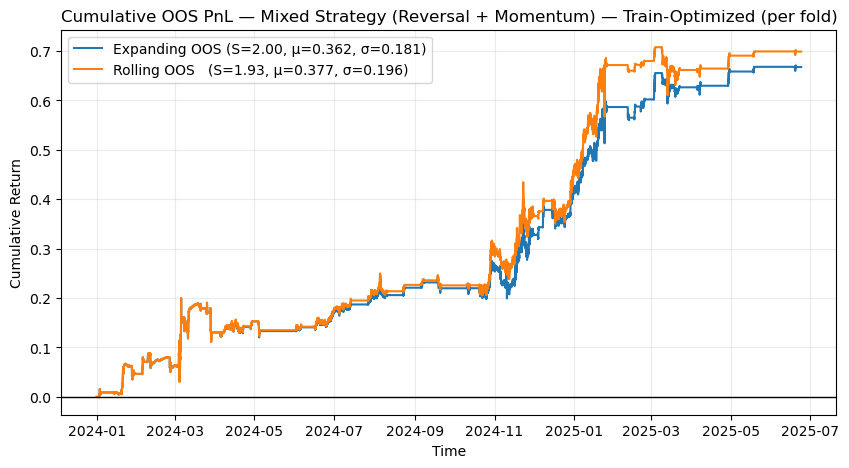

,ann_ret,ann_vol,sharpe
Expanding — Train-Optimized (per fold),0.362,0.181,1.999
Rolling — Train-Optimized (per fold),0.377,0.196,1.928


In [7]:
def _mix_label(df):
    try:
        mode = str(df["mix_mode"].iloc[0])
    except Exception:
        mode = "unknown"
    return {
        "equal_vol": "Equal-Vol (risk parity)",
        "train_opt": "Train-Optimized (per fold)",
        "static":    "Static (fixed weight)",
        "5050":      "50/50 static",
        "unknown":   "Mixed (unspecified)"
    }.get(mode, mode)

lbl_exp  = _mix_label(exp_df_mix)
lbl_roll = _mix_label(roll_df_mix)
title_lbl = lbl_exp if lbl_exp == lbl_roll else f"{lbl_exp} / {lbl_roll}"

def _row(series):
    d = perf_stats(series.dropna())
    return {"ann_ret": d.get("ann_ret"), "ann_vol": d.get("ann_vol"), "sharpe": d.get("sharpe")}

summary_df = pd.DataFrame({
    f"Expanding — {lbl_exp}": _row(exp_oos_mix),
    f"Rolling — {lbl_roll}":  _row(roll_oos_mix),
}).T
# --- Plot cumulative OOS PnL with informative legends
fig, ax = plt.subplots(figsize=(10, 5))

stats_e = perf_stats(exp_oos_mix.dropna())
stats_r = perf_stats(roll_oos_mix.dropna())

lab_e = f"Expanding OOS (S={stats_e['sharpe']:.2f}, μ={stats_e['ann_ret']:.3f}, σ={stats_e['ann_vol']:.3f})"
lab_r = f"Rolling OOS   (S={stats_r['sharpe']:.2f}, μ={stats_r['ann_ret']:.3f}, σ={stats_r['ann_vol']:.3f})"

cum_e = (1 + exp_oos_mix.dropna()).cumprod() - 1
cum_r = (1 + roll_oos_mix.dropna()).cumprod() - 1

ax.plot(cum_e.index, cum_e.values, label=lab_e)
ax.plot(cum_r.index, cum_r.values, label=lab_r)

ax.axhline(0, color="black", lw=1)
ax.set_title(f"Cumulative OOS PnL — Mixed Strategy (Reversal + Momentum) — {title_lbl}")
ax.set_ylabel("Cumulative Return"); ax.set_xlabel("Time")
ax.legend(); ax.grid(True, alpha=0.25)

# >>> Save to figs/ <<<
figs = PROJECT_ROOT / "figs"
figs.mkdir(parents=True, exist_ok=True)
slug = (title_lbl.lower()
        .replace("—","-").replace("–","-").replace("/","_")
        .replace("(", "").replace(")", "").replace(" ", "-"))
fname = f"mixed_oos_pnl_{slug}.png"
fig.savefig(figs / fname, dpi=180, bbox_inches="tight")
print("Saved figure to:", figs / fname)

plt.show()

display(summary_df.round(3))

In [8]:
# --- Stitched OOS series ---
series_map = {
    "Expanding OOS": exp_oos_mix,   # stitched OOS net returns
    "Rolling OOS":   roll_oos_mix,
}

# HAC lag: tie to slower sleeve cadence (momentum); default to 720 if not defined
try:
    hac_lag = max(24, int(every_mom))
except NameError:
    hac_lag = 720

rows = []
for label, r in series_map.items():
    # compute_alpha_beta returns: alpha_ann, alpha_t, beta, beta_t, R2, n_obs
    res = compute_alpha_beta(r, bench_ret, freq=ANNUALIZATION, lag_bars=hac_lag)
    res["label"] = label
    rows.append(res)

alpha_beta_df = pd.DataFrame(rows).set_index("label").round(3)

display(alpha_beta_df)

,alpha_ann,alpha_t,beta,beta_t,R2,n_obs
label,,,,,,
Expanding OOS,0.380,3.216,-0.029,-2.222,0.007,12960
Rolling OOS,0.395,3.031,-0.028,-2.052,0.005,12960


## Results & Interpretation (Mixed Strategy)

### OOS performance — **train-optimized mix** (stitched, net of costs)
- **Expanding:** **Sharpe 2.00**, ann. ret **0.362**, ann. vol **0.181**
- **Rolling:**   **Sharpe 1.93**, ann. ret **0.377**, ann. vol **0.196**

*Cross-fold (per-fold) summary for train-optimized weights:*  
Expanding — mean Sharpe **2.213** (median **2.132**), mean **w_mom ≈ 0.40**  
Rolling — mean Sharpe **2.144** (median **2.184**), mean **w_mom ≈ 0.51**

### Alpha/Beta vs BTC (HAC / Newey–West)
Using **12,960 hourly obs**:
- **Expanding OOS:** **αₐₙₙ = 0.380**, **t(α) = 3.216**; **β = −0.029**, **t(β) = −2.222**; **R² = 0.007**.
- **Rolling OOS:**   **αₐₙₙ = 0.395**, **t(α) = 3.031**; **β = −0.028**, **t(β) = −2.052**; **R² = 0.005**.

**Interpretation:** Alpha is **positive and statistically significant** in both splits; beta is **small and negative**, with **near-zero R²**, indicating returns largely **orthogonal to BTC**.

### Cost sensitivity — **equal-vol mix** (for reference)
- **7 bps:**  Exp **2.57**, Roll **2.57**  
- **10 bps:** Exp **2.47**, Roll **2.47**  
- **20 bps:** Exp **2.11**, Roll **2.12**

*(Equal-vol remains very cost-resilient; train-optimized mix uses per-fold Sharpe on TRAIN and shows slightly lower stitched OOS Sharpe, consistent with shorter train windows and weight variability.)*

### Takeaways
- The mixed sleeve delivers **strong OOS Sharpe** with **significant alpha vs BTC** and minimal benchmark dependence.  
- **Train-optimized weights** center around **40–50% momentum** and perform well; the **equal-vol** blend remains a **robust baseline** with especially strong cost robustness.